In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from porousmedialab.column import Column
import numpy as np
import seaborn as sns
%matplotlib inline

In [ ]:
# for i in range(10):

w = 0.2
t = 1
dx = 0.2
L = 15
phi = 0.9
dt = 1e-2

sediment = Column(L, dx, t, dt, w)

# Bacteria:
sediment.add_species(theta=phi, element='X_A', init_conc=5e-4, D=100, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='X_F', init_conc=5e-4, D=100, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='X_N', init_conc=5e-4, D=100, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='X_Fe', init_conc=5e-4, D=100, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='X_S', init_conc=5e-4, D=5, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')

# Solids
sediment.add_species(theta=1-phi, element='POM', D=5, init_conc=1e-5, bc_top_value=3e-5, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=1-phi, element='FeOOH', D=5, init_conc=1e-3, bc_top_value=1e-4, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=1-phi, element='Fe2sorb', D=5, init_conc=1e-10, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')

# Dissolved
sediment.add_species(theta=phi, element='C6H12O6', D=100, init_conc=1e-6, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='CH3COO', D=100, init_conc=1e-6, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='H2', D=200, init_conc=1e-6, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='O2', D=375, init_conc=1e-6, bc_top_value=0.3e-3, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='NO3', D=344, init_conc=1e-6, bc_top_value=1e-4, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='Fe2', D=344, init_conc=1e-6, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='HS', D=344, init_conc=1e-6, bc_top_value=0, bc_top_type='flux', bc_bot_value=0, bc_bot_type='flux')
sediment.add_species(theta=phi, element='SO4', D=344, init_conc=1e-4, bc_top_value=1e-4, bc_top_type='constant', bc_bot_value=0, bc_bot_type='flux')


sediment.load_initial_conditions()

sediment.add_partition_equilibrium('Fe2', 'Fe2sorb', 0.2)

sediment.constants['F'] = phi / (1 - phi)
sediment.constants['H'] = 1e-6  # Constant pH
sediment.constants['HCO3'] = 1e-4  # Constant pH
sediment.constants['N2'] = 1e-6  # Constant N2
sediment.constants['T'] = 273.15 + 20
sediment.constants['R'] = 8.31446  # J/K/mol gas constant
sediment.constants['Far'] = 96485  # Faraday;
sediment.constants['dKsi'] = 0.2  # V


# Gibbs
# 2) Fermentation


# 3) Aerobic respiration of glucose




# Funcitons
# Thermodynamic limitting function
sediment.functions['Ft'] = 'lambda dGr : 1 / (np.exp((dGr + F * dKsi) / R / T) + 1)'



# Reactions
# 1) Hydrolysis
# POM = 10 * C6H12O6
sediment.constants['k_hydr'] = 0.1
sediment.rates['R_hydr'] = 'k_hydr * POM'


# 2) Fermentation of glucose:
# C6H12O6 + 4 H2O = 2CH3COO- + 2HCO3- + 4H+ + 4H2
sediment.constants['K_MAX_F'] = 3.8
sediment.constants['K_M_C6H12O6'] = 1.1e-4
sediment.constants['dG0_ferm'] = 3002.4811336575965  # J/mol-e
sediment.rates['dG_ferm'] = 'dG0_ferm + R * T * np.log (CH3COO**2*HCO3**2*H**4*H2**4/C6H12O6) / 8'
sediment.rates['Ft_ferm'] = 'Ft(dG_ferm)'
sediment.rates['r_ferm'] = 'K_MAX_F * X_F * C6H12O6 / (K_M_C6H12O6 + C6H12O6) * Ft(dG_ferm)'

# 3) Aerobic respiration of glucose
# C6H12O6 + 6O2  -> 6HCO3- + 6H
sediment.constants['K_MAX_glu_o2'] = 3.8
sediment.constants['K_M_O2'] = 1e-6
sediment.constants['dG0_glu_o2'] = -112673.05075744872  # J/mol-e 
sediment.rates['dG_glu_o2'] = 'dG0_glu_o2 + R * T * np.log (HCO3**6*H**6/C6H12O6/O2**6) / 24'
sediment.rates['Ft_glu_o2'] = 'Ft(dG_glu_o2)'
sediment.rates['r_glu_o2'] = 'K_MAX_glu_o2 * X_A * C6H12O6 / (K_M_C6H12O6 + C6H12O6) * O2 / (K_M_O2 + O2) * Ft(dG_glu_o2)'

# 4) Denitrification with acetate
# CH3COO- + 8/5 NO3- + 3/5 H+  => 4/5 N2 + 4/5 H2O + 2HCO3-
sediment.constants['K_MAX_a1'] = 3.8
sediment.constants['K_M_CH3COO'] = 5e-4
sediment.constants['K_M_NO3'] = 8.1e-6
sediment.constants['dG0_A1'] = -100002.22123387559
sediment.rates['dG_A1'] = 'dG0_A1 + R * T * np.log (HCO3**2*N2**(4/5)/CH3COO/NO3**(8/5)) / 8'
sediment.rates['Ft_A1'] = 'Ft(dG_A1)'
sediment.rates['r_a1'] = 'K_MAX_a1 * X_N * CH3COO / (K_M_CH3COO + CH3COO) * NO3 / (K_M_NO3 + NO3) * Ft(dG_A1)'


# 5) Denitrification with hydrogen
# H2 + 0.4NO3- + 0.4H+ -> 1.2H2O + 0.2N2
sediment.constants['K_MAX_h1'] = 3.8
sediment.constants['K_M_H2'] = 1e-9
sediment.constants['dG0_H1'] = -126868.85925165186
sediment.rates['dG_H1'] = 'dG0_H1 + R * T * np.log (N2**(0.2)/H2/NO3**(0.4)) / 2'
sediment.rates['Ft_H1'] = 'Ft(dG_H1)'
sediment.rates['r_h1'] = 'K_MAX_h1 * X_N * H2 / (K_M_H2 + H2) * NO3 / (K_M_NO3 + NO3) * Ft(dG_H1)'

# 6) Iron reduction A3
# CH3COO- + 8FeOOH + 15H+ -> 8Fe^{2+} +2HCO3- + 12H2O
sediment.constants['K_MAX_a3'] = 3.8
sediment.constants['K_M_FeOOH'] = 1.5e-3
sediment.constants['dG0_A3']  = -55538.281485829316
sediment.rates['dG_A3'] = 'dG0_A3 + R * T * np.log (HCO3**2*Fe2**8/CH3COO/H**15) / 8'
sediment.rates['Ft_A3'] = 'Ft(dG_A3)'
sediment.rates['r_a3'] = 'K_MAX_a3 * X_Fe * CH3COO / (K_M_CH3COO + CH3COO) * FeOOH / (K_M_FeOOH + FeOOH) * Ft(dG_A3)'


# 7) Iron oxidation
# Fe2+ + 1/4 O2 + 2HCO3 + 1/2 H2O=> Fe(OH) +2CO2
sediment.constants['K_feox'] = 1e+4
sediment.rates['r_s1'] = 'K_feox*Fe2*O2'

# 8) Iron reduction H3
# H2 + 2FeOOH + 4H+ -> 4H2O + 2Fe2+
sediment.constants['K_MAX_h3'] = 3.8
sediment.constants['dG0_H3'] = -82404.91950360553
sediment.rates['dG_H3'] = 'dG0_H3 + R * T * np.log (Fe2**8/H2/H**4) / 2'
sediment.rates['Ft_H3'] = 'Ft(dG_H3)'
sediment.rates['r_h3'] = 'K_MAX_h3 * X_Fe * H2 / (K_M_H2 + H2) * FeOOH / (K_M_FeOOH + FeOOH) * Ft(dG_H3)'

# 9) Sulphate reduction A4
# CH3COO- + SO42- = HS- + 2HCO3-
sediment.constants['K_MAX_A4'] = 3.8
sediment.constants['K_M_SO4'] = 1e-6
sediment.constants['dG0_A4'] = -5869.779263793404
sediment.rates['dG_A4'] = 'dG0_A4 + R * T * np.log (HS*HCO3**2/CH3COO/SO4) / 8'
sediment.rates['Ft_A4'] = 'Ft(dG_A4)'
sediment.rates['r_a4'] = 'K_MAX_A4 * X_S * CH3COO / (K_M_CH3COO + CH3COO) * SO4 / (K_M_SO4 + SO4) * Ft(dG_A4)'


# 10) Sulphate oxidation 
# HS- +2O2 = H+ + SO42-
sediment.constants['K_sox'] = 1e+4
sediment.rates['r_s2'] = 'K_sox*HS*O2'

# 11) Sulphade reduction H4
# H2 + 0.25SO42- + 0.25H+ -> H2O + 0.25HS-
sediment.constants['K_MAX_h4'] = 3.8
sediment.constants['dG0_H4'] = -32736.41728156967
sediment.rates['dG_H4'] = 'dG0_H4 + R * T * np.log (HS**0.25/H2/SO4**0.25/H**0.25) / 2'
sediment.rates['Ft_H4'] = 'Ft(dG_H4)'
sediment.rates['r_h4'] = 'K_MAX_h4 * X_S * H2 / (K_M_H2 + H2) * SO4 / (K_M_SO4 + SO4) * Ft(dG_H4)'


# 12) Aerobic respiration of glucose
# C6H12O6 + 4.8 NO3- + -> 6HCO3- + 1.2 H+ + 2.4 N2(aq) + 2.4 H2O
sediment.constants['K_MAX_glu_no3'] = 3.8
sediment.constants['dG0_glu_no3'] = -107956.94019524849  # J/mol-e 
sediment.rates['dG_glu_no3'] = 'dG0_glu_no3 + R * T * np.log (HCO3**6*H**1.2*N2**2.4/C6H12O6/NO3**4.8) / 24'
sediment.rates['Ft_glu_no3'] = 'Ft(dG_glu_no3)'
sediment.rates['r_glu_no3'] = 'K_MAX_glu_no3 * X_N * C6H12O6 / (K_M_C6H12O6 + C6H12O6) * NO3 / (K_M_NO3 + NO3) * Ft(dG_glu_no3)'

# dcdt
sediment.dcdt['X_F'] = '1.2 * r_ferm - 0.5 * X_F' 
sediment.dcdt['X_A'] = '5 * r_glu_o2 - 0.5 * X_A' 
sediment.dcdt['X_N'] = '5 * r_glu_no3 + 1.2 * r_a1 + 1.0 * r_h1 - 0.5 * X_N' 
sediment.dcdt['X_Fe'] = '2.0 * r_a3 + 1.5 * r_h3 - 0.5 * X_Fe'
sediment.dcdt['X_S'] = '1.2 * r_a4 + 1.0 * r_h4 - 0.5 * X_S'
sediment.dcdt['POM'] = '- R_hydr'
sediment.dcdt['C6H12O6'] = '20 * R_hydr - r_glu_o2 - r_glu_no3 - r_ferm'
sediment.dcdt['H2'] = '4 * r_ferm - r_h1 - r_h3 - r_h4'
sediment.dcdt['CH3COO'] = '2 * r_ferm - r_a1 - r_a3 - r_a4'
sediment.dcdt['O2'] = '- 6 * r_glu_o2 - 1/4*r_s1 - 2*r_s2'
sediment.dcdt['NO3'] = '- 8/5 * r_a1 - 0.4 * r_h1 - 4.8 * r_glu_no3'
sediment.dcdt['FeOOH'] = '- 8 * r_a3/F + r_s1/F - 2*r_h3/F'
sediment.dcdt['Fe2'] = '8 * r_a3 - r_s1 + 2*r_h3'
sediment.dcdt['SO4'] = '-r_a4 + r_s2 - 0.25 * r_h4'
sediment.dcdt['HS'] = 'r_a4 - r_s2 + 0.25*r_h4'

sediment.solve()
sediment.save_final_profiles()

Simulation started:
	 2018-09-10 18:10:46


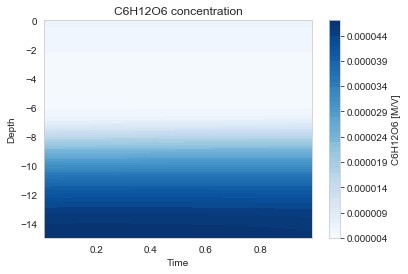

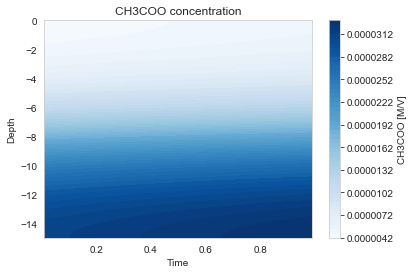

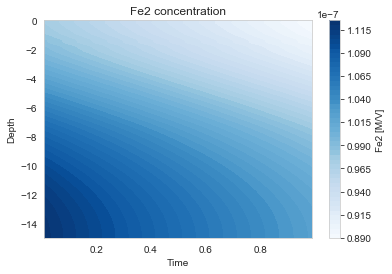

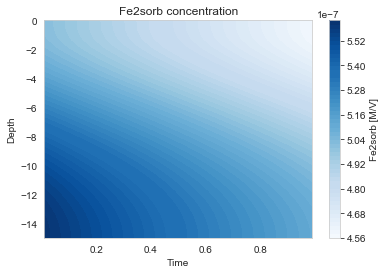

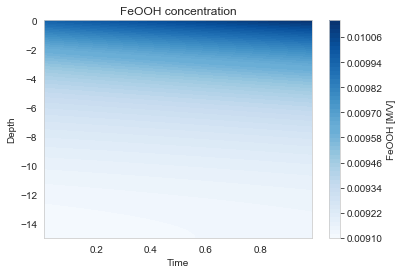

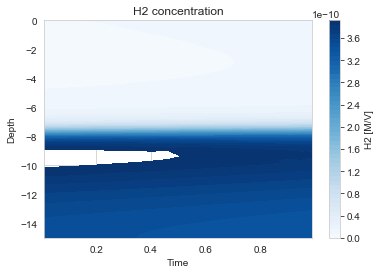

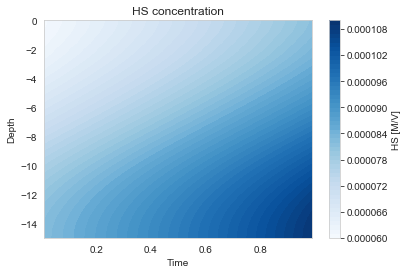

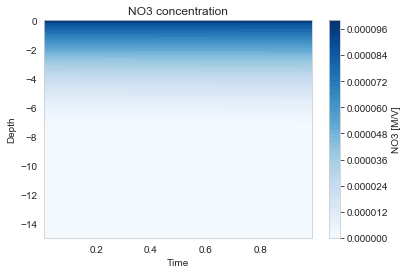

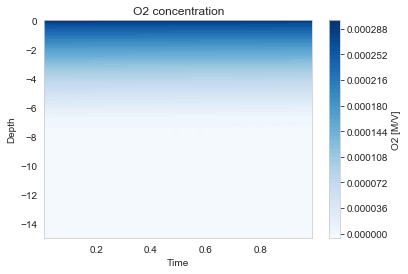

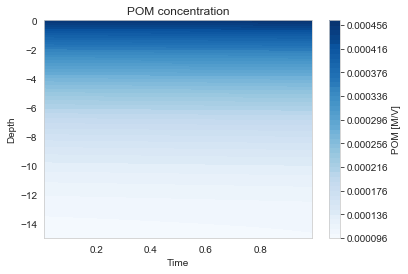

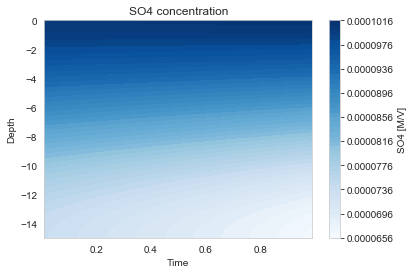

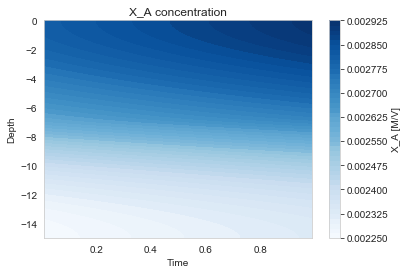

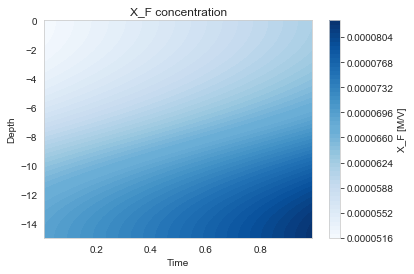

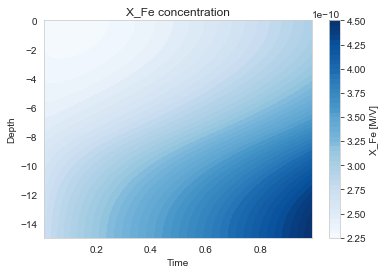

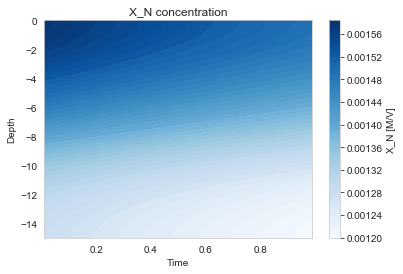

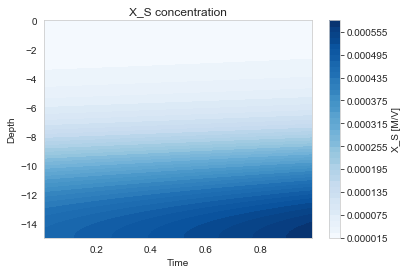

In [162]:
sediment.plot_contourplots()

In [163]:
sediment.reconstruct_rates()

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


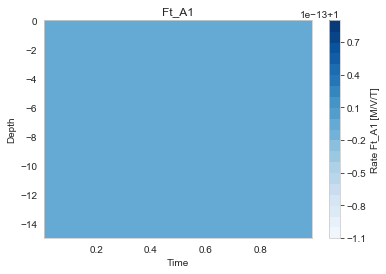

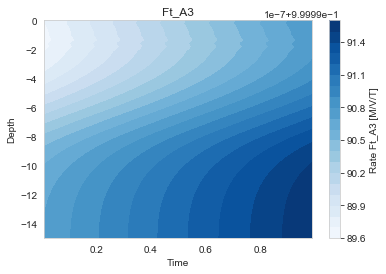

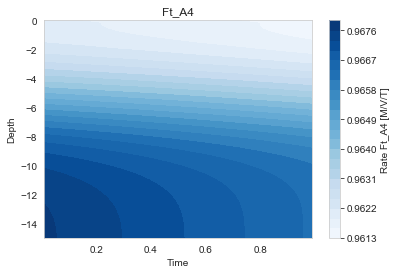

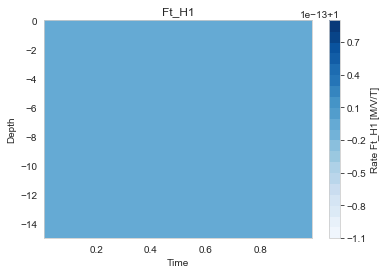

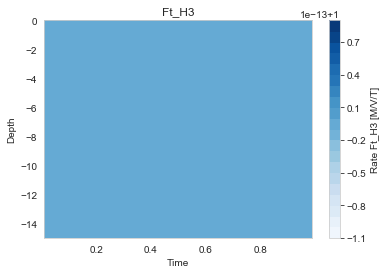

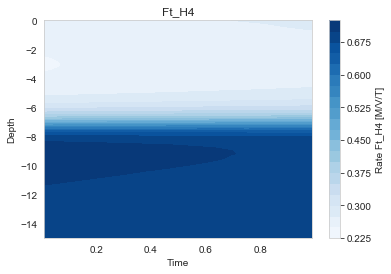

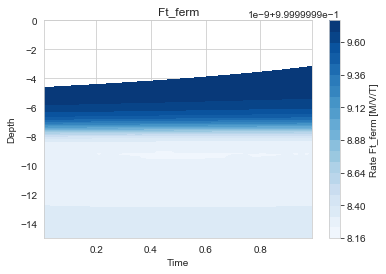

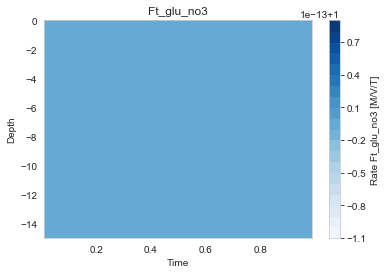

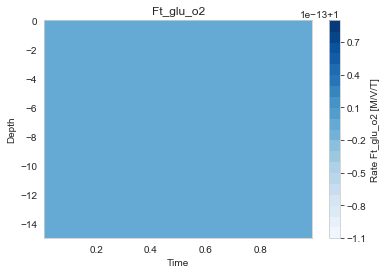

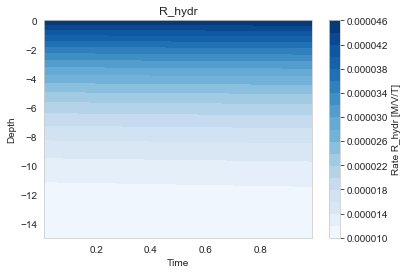

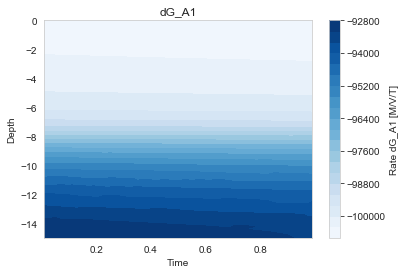

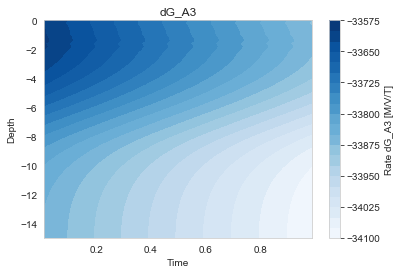

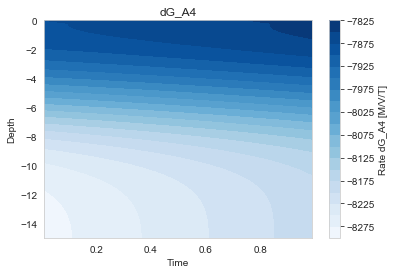

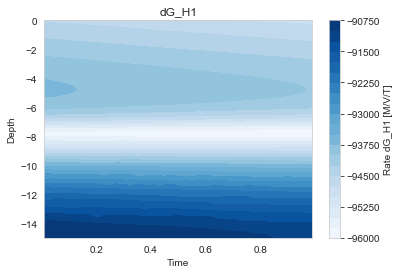

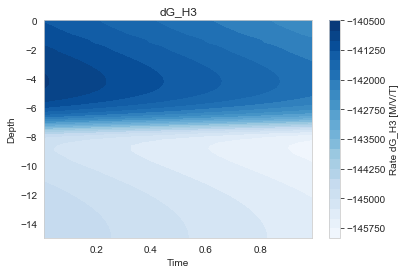

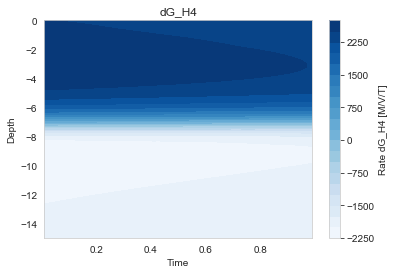

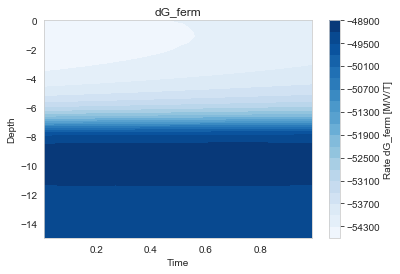

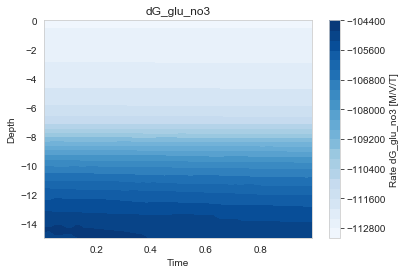

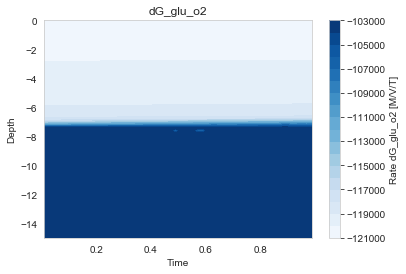

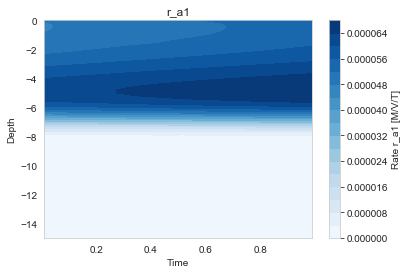

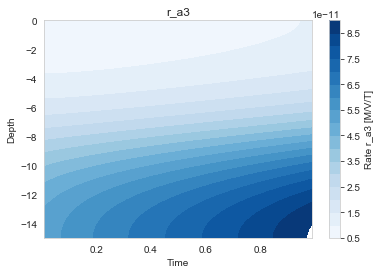

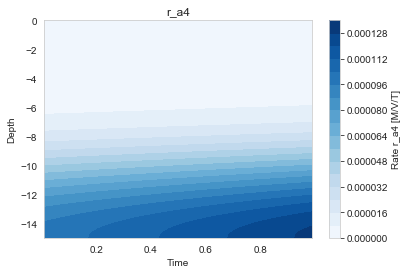

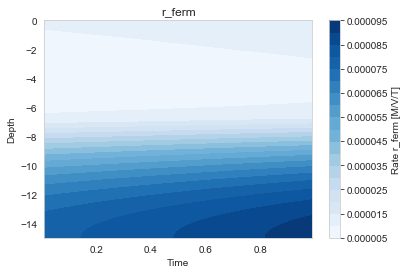

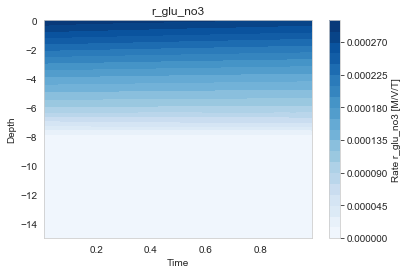

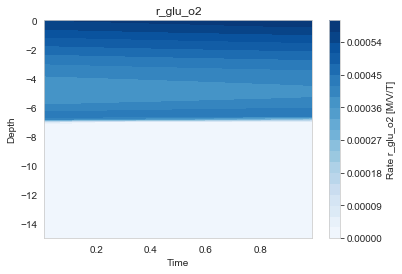

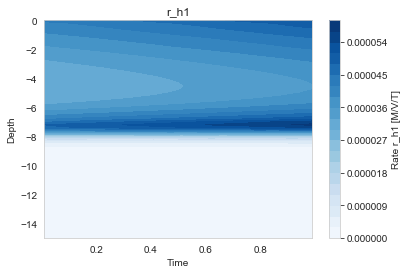

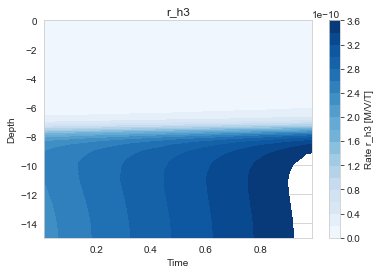

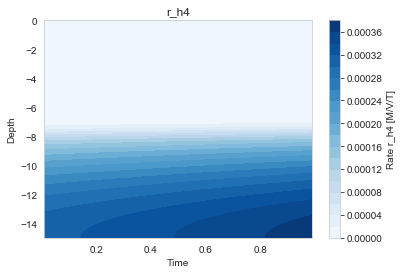

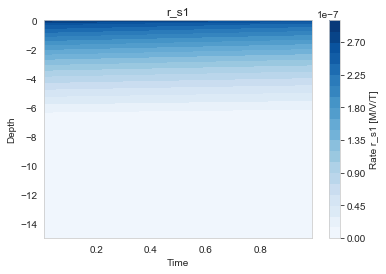

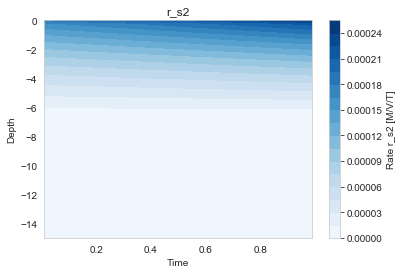

In [ ]:
sediment.plot_contourplots_of_rates()